**Imports**

In [4]:
import random
import operator
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp
from sklearn.metrics import confusion_matrix


C:\Users\The_M\AppData\Local\Temp\ipykernel_25728\2553882578.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
train_data = pd.read_csv('train-Copy1.csv')
test_data = pd.read_csv('test-Copy1.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
random.seed(100)
np.random.seed(100)

train_data.drop(columns=['Name', 'Ticket', 'Cabin', 'Embarked'], inplace=True)
train_data.set_index(keys=['PassengerId'], drop=True, inplace=True)

test_data.drop(columns=['Name', 'Ticket', 'Cabin', 'Embarked'], inplace=True)
test_data.set_index(keys=['PassengerId'], drop=True, inplace=True)

train_nan_map = {'Age': train_data['Age'].mean(), 'Fare': train_data['Fare'].mean()}
test_nan_map = {'Age': test_data['Age'].mean(), 'Fare': test_data['Fare'].mean()}

train_data.fillna(value=train_nan_map, inplace=True)
test_data.fillna(value=test_nan_map, inplace=True)

columns_map = {'Sex': {'male': 0, 'female': 1}}
train_data.replace(columns_map, inplace=True)
test_data.replace(columns_map, inplace=True)

X_train = train_data.loc[:, train_data.columns != 'Survived']
y_train = train_data.loc[:, 'Survived']

#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=10)

C:\Users\The_M\AppData\Local\Temp\ipykernel_25728\2742420622.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data.replace(columns_map, inplace=True)
C:\Users\The_M\AppData\Local\Temp\ipykernel_25728\2742420622.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_data.replace(columns_map, inplace=True)


**Multiple Objective Genetic Programming**
- we will be minimizing False Postitives and False negatives

In [7]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

**Define Useful Functions**

In [8]:
def mod_floor_div(num, denom):
    try: 
        return num// denom
    except ZeroDivisionError:
        return 1

def mod_true_div(num, denom):
    try:
        return num / denom
    except ZeroDivisionError:
        return 1

def if_then_else(expression, first, second):
    if expression:
        return first
    else:
        return second

def sigmoid(x):
    if x < 0:
        return 1 - (1 / (1 + math.exp(x)))
    return 1 / (1 + math.exp(-x))

def weightedSum(inputs, weights):
    val = sum(x*y for x,y in zip(inputs, cycle(weights)))
    return val
        
def make_three_list(one, two, three):
    return [one, two, three]

**Add Primitives**

In [9]:
random.seed(1852)

pset = gp.PrimitiveSetTyped("TITANIC", [float, float, float, float, float, float], bool)
#pset = gp.PrimitiveSetTyped("TITANIC", [list], bool)

pset.renameArguments(ARG0="Pclass", ARG1="Sex", ARG2="Age", ARG3="SibSp", ARG4="Parch", ARG5="Fare")

pset.addPrimitive(operator.and_, [bool, bool], bool);
pset.addPrimitive(operator.or_, [bool, bool], bool);
pset.addPrimitive(operator.not_, [bool], bool);
pset.addPrimitive(operator.xor, [bool, bool], bool);

pset.addPrimitive(operator.lt, [float, float], bool)
pset.addPrimitive(operator.le, [float, float], bool)
pset.addPrimitive(operator.eq, [float, float], bool)
pset.addPrimitive(operator.ne, [float, float], bool)
pset.addPrimitive(operator.ge, [float, float], bool)
pset.addPrimitive(operator.gt, [float, float], bool)


pset.addPrimitive(operator.add, [float, float], float)
pset.addPrimitive(operator.sub, [float, float], float)
pset.addPrimitive(operator.mul, [float, float], float)

pset.addPrimitive(mod_floor_div, [float, float], float)
pset.addPrimitive(mod_true_div, [float, float], float)
pset.addPrimitive(if_then_else, [bool, float, float], float)
pset.addPrimitive(sigmoid, [float], float)
#pset.addPrimitive(weightedSum, [list, list], float)
#pset.addPrimitive(random.choice, [list], float)
#pset.addPrimitive(make_three_list, [float, float, float], list)



pset.addTerminal(True, bool)
pset.addTerminal(False, bool)


**Make the Toolbox**

Selection	Migration			
initRepeat()	cxOnePoint()	mutGaussian()	selTournament()
initIterate()	cxTwoPoint()	mutShuffleIndexes()	selRoulette()	
initCycle    ()	cxUniform    ()	mutFlipBit    ()	selNSGA2(        )    	
	cxPartialyMatched()	mutPolynomialBounded()	selNSGA3            ()	
	cxUniformPartialyMatched()	mutUniformInt()	selSPEA            2()	
	cxOrd  ered()	mutESLogNormal()	selRand            om()	
	cxBl                    end()		selB            est()	
	cxESB                    lend()		selW            orst()	
	cxESTwo                Point()		selTourname            ntDCD()	
	cxSimulated            Binary()		selDoubleTour            nament()	
	cxSimulatedBinary    Bounded()		selStochasticUniversalS            ampling()	
	cxMessy            OnePoint()		selLex                                        icase()	
			selEpsilonLe                                        xicase()	
			selAutomaticEpsilonLexicase()	

In [10]:
def evaluate_individual(individual, pset):
    #whats the difference between gp.compile vs toolbox.compile? 
    #they take in a differnt set of arugmetns but what do they actually mean?
    indFunction = gp.compile(expr=individual, pset=pset)

    #y_pred = list(map(indFunction, *X_train.values.tolist()))
    y_pred = []
    for passenger in X_train.values.tolist():
        y_pred.append(1 if indFunction(*passenger) else 0)
    
    conf_mat = confusion_matrix(y_train, y_pred)

    false_negative_rate = conf_mat[1][0] / (conf_mat[1][0] + conf_mat[1][1])
    false_positive_rate = conf_mat[0][1] / (conf_mat[0][1] + conf_mat[0][0])
    
    return false_negative_rate, false_positive_rate
    

In [11]:
toolbox = base.Toolbox()
#play around with tree min and max heights
toolbox.register("expr", gp.genHalfAndHalf, pset = pset, min_ = 1, max_ = 4) 
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset = pset)

#evaluate
#select
#mate
#mutate

toolbox.register("evaluate", evaluate_individual, pset = pset)
#try selcetion nsga2, nsga3, spea2
#toolbox.register("select", tools.selTournament)
toolbox.register("select", tools.selNSGA2,nd='standard')

#test differnt matings here
toolbox.register("mate", gp.cxOnePoint)
#look into what this line of code actually does -> genFull will geneerate an indivitual/ tree with all elveas of same height
toolbox.register("expr_mut", gp.genFull, min_ = 0, max_ = 2)
#the following line randomlly picks a point and repalces that subtree with what is generated by the experession fed in
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset = pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=20))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=20))


**Genetic Algorithm Loop**

In [12]:
def print_stats(list, avglist, stdlist):
    length = len(list)
    mean = sum(list)/ length
    #used the actual standard deviation formula instead of the one form lab2
    #sum_sqrd = sum(x*x for x in list)
    sqr_error = sum((x-mean)**2 for x in list)
    std = (sqr_error / length)**0.5


    print("Mean: " , mean)
    print("SD: " , std)

    avglist.append(mean)
    stdlist.append(std)


In [15]:
def evo_algo(pop_size, generations, mate_prob, mutation_prob, popul = toolbox.population(n=1000)):
    """
        pop_size = 1000
        generations = 100
        mate_prob = 0.4
        mutation_prob = 0.2
    """
    fnr_avg_list = []
    fnr_std_list = []
    fpr_avg_list = []
    fpr_std_list = []    
    #popul = toolbox.population(n=pop_size)
    while (len(popul) < pop_size):
        popul = list(map(toolbox.clone, popul))
    #evaluate
    #evalueates and assigns all individuals in the population to initialize
    fitnesses = list(map(toolbox.evaluate, popul))
    
    for ind, fit in zip(popul, fitnesses):
        ind.fitness.values = fit

    popul = tools.selBest(popul, pop_size)
    
    #simulating new generations
    for gen in range(generations):
        print("---------Generation %i ------------" % gen)
        #select
        next_generation = toolbox.select(popul, len(popul))
        next_generation = list(map(toolbox.clone, next_generation))
        
        #mate
        for child_one, child_two in zip(next_generation[::2], next_generation[1::2]):
            if (random.random() < mate_prob):
                toolbox.mate(child_one, child_two)
                del child_one.fitness.values
                del child_two.fitness.values
        
        #mutate
        for child in next_generation:
            if (random.random() < mutation_prob):
                toolbox.mutate(child)
                del child.fitness.values
    
        #congregates all the indiviuals who do not have a fitness value and revalueates them
        reval = [ind for ind in next_generation if not ind.fitness.valid]
        reval_fitness = map(toolbox.evaluate, reval)
        for ind, fit in zip(reval, reval_fitness):
            ind.fitness.values = fit
    
    
        popul[:] = next_generation
    
        fnr_fitness = [ind.fitness.values[0] for ind in popul]
        fpr_fitness = [ind.fitness.values[1] for ind in popul]
    
        print("-----FNR----")
        print_stats(fnr_fitness, fnr_avg_list, fnr_std_list)
        print("-----FPR----")
        print_stats(fpr_fitness, fpr_avg_list, fpr_std_list)
        
    best_individual = tools.selBest(popul, 1)[0]
    print("Best got FNR: %s, FPR: %s" % (best_individual.fitness.values[0], best_individual.fitness.values[1]))
    return popul

In [ ]:

fnr_avg_list = []
fnr_std_list = []
fpr_avg_list = []
fpr_std_list = []

pop_size = 1000
generations = 100
mate_prob = 0.4
mutation_prob = 0.2

popul = toolbox.population(n=pop_size)

#evaluate
#evalueates and assigns all individuals in the population to initialize
fitnesses = list(map(toolbox.evaluate, popul))

for ind, fit in zip(popul, fitnesses):
    ind.fitness.values = fit

#simulating new generations
for gen in range(generations):
    print("---------Generation %i ------------" % gen)
    #select
    next_generation = toolbox.select(popul, len(popul))
    next_generation = list(map(toolbox.clone, next_generation))
    
    #mate
    for child_one, child_two in zip(next_generation[::2], next_generation[1::2]):
        if (random.random() < mate_prob):
            toolbox.mate(child_one, child_two)
            del child_one.fitness.values
            del child_two.fitness.values
    
    #mutate
    for child in next_generation:
        if (random.random() < mutation_prob):
            toolbox.mutate(child)
            del child.fitness.values

    #congregates all the indiviuals who do not have a fitness value and revalueates them
    reval = [ind for ind in next_generation if not ind.fitness.valid]
    reval_fitness = map(toolbox.evaluate, reval)
    for ind, fit in zip(reval, reval_fitness):
        ind.fitness.values = fit


    popul[:] = next_generation

    fnr_fitness = [ind.fitness.values[0] for ind in popul]
    fpr_fitness = [ind.fitness.values[1] for ind in popul]

    print("-----FNR----")
    print_stats(fnr_fitness, fnr_avg_list, fnr_std_list)
    print("-----FPR----")
    print_stats(fpr_fitness, fpr_avg_list, fpr_std_list)
    
    

best_individual = tools.selBest(popul, 1)[0]
print("Best got FNR: %s, FPR: %s" % (best_individual.fitness.values[0], best_individual.fitness.values[1]))



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
print(len(popul))
#  Fairly fast for many datapoints, less fast for many dimensions
def find_pareto(data):
    is_Pareto = np.ones(data.shape[0], dtype = bool)
    for i, c in enumerate(data):
        # Keep any point with a lower cost
        if is_Pareto[i]:
            # This is where you would change for miniminzation versus maximization 

            # Minimization
            is_Pareto[is_Pareto] = np.any(data[is_Pareto]<c, axis=1)  

            # Maximization
            #is_Pareto[is_Pareto] = np.any(data[is_Pareto]>c, axis=1)  

            # And keep self
            is_Pareto[i] = True  

    # Downsample from boolean array
    Pareto_data = data[is_Pareto, :]

    # Sort data
    Pareto_out =  Pareto_data[np.argsort(Pareto_data[:,0])]

    #return is_Pareto
    return Pareto_out

# Create random list of values

myData = [ind.fitness.values for ind in popul]

# Include the trival Pareto points, i.e. always on or off
myData = np.vstack(([[0,1],[1,0]], myData))

# Use above routine to find pareto points
myPareto=find_pareto(myData)

# Calculate the Area under the Curve as a Riemann sum
auc = np.sum(np.diff(myPareto[:,0])*myPareto[0:-1,1])

# Create figure
plt.figure()

# Make sure font sizes are large enough to read in the presentation
plt.rcParams.update({'font.size': 14})

# Plot all points
plt.scatter(myData[:,0],myData[:,1],)

# Plot Pareto steps. note 'post' for minimization 'pre' for maximization
plt.step(myPareto[:,0], myPareto[:,1], where='post')
#plt.step(myPareto[:,0], myPareto[:,1], where='pre')

# Make sure you include labels
# Minimization
plt.title('Example of a Minimization Result\n with AUC = ' + str(auc))
plt.xlabel('False Negative')
plt.ylabel('False Positive')

# Maximization
#plt.title('Example of a Maximization Result')
#plt.xlabel('True Negative')
#plt.ylabel('True Positive')

plt.show()

In [23]:
def paretoDominance(ind1,ind2):
    if ((ind1[0] < ind2[0]) and (ind1[1] < ind2[1])):
        return 1
    if ((ind2[0] < ind1[0]) and (ind2[1] < ind1[1])):
        return -1
    return 0

def plotPareto(popul, paretoIndividualGroup):
    individual_fitnesses = [(*ind.fitness.values,ind) for ind in popul]
    pareto_frontier=[]
    non_frontier=[]
    
    for model1 in individual_fitnesses:
        pareto = True
        for model2 in individual_fitnesses:
            if (paretoDominance(model1,model2) == -1):
                pareto = False
        if pareto:
            pareto_frontier.append(model1)
            paretoIndividualGroup.append(model1[2])
        else:
            non_frontier.append(model1)
    
    pareto_frontier.sort(key=lambda x: x[1])
    pareto_frontier_x = [model[0] for model in pareto_frontier]
    pareto_frontier_y = [model[1] for model in pareto_frontier]
    non_frontier_x = [model[0] for model in non_frontier]
    non_frontier_y = [model[1] for model in non_frontier]
    print(len(pareto_frontier))
    print(len(non_frontier))
    #add noahs
    models_x = sorted([0,1,0.146596858639, 0.141361256545, 0.13612565445, 0.127068062827, 0.15183246073])
    models_y = [1,0.432692307692, 0.326923076923, 0.270384615385, 0.269230769231,0.24545454545,0 ]
    plt.scatter(non_frontier_x,non_frontier_y,color="r",label="Non Frontier")
    plt.scatter(pareto_frontier_x,pareto_frontier_y,color="g",label="Pareto Frontier")
    plt.plot(pareto_frontier_x,pareto_frontier_y, color="g",drawstyle='steps') #Doesn't draw Steps post when I set drawstyle to 'steps-post'?
    plt.xlabel("False Negative Rate (FNR)")
    plt.ylabel("False Positive Rate (FPR)")
    plt.title("Pareto Frontier of MOGP")
    plt.legend(loc='upper right')
    plt.show()
    
    plt.scatter(models_x,models_y,color='b',label="ML")
    plt.plot(models_x,models_y,color='b',drawstyle='steps-post')
    plt.xlabel("False Negative Rate (FNR)")
    plt.ylabel("False Positive Rate (FPR)")
    plt.title("Pareto Frontier of ML")
    plt.legend(loc='upper right')
    plt.show()
    
    plt.scatter(models_x,models_y,color='b',label="ML")
    plt.scatter(non_frontier_x,non_frontier_y,color="r",label="Non Frontier")
    plt.scatter(pareto_frontier_x,pareto_frontier_y,color="g",label="Pareto Frontier")
    plt.plot(models_x,models_y,color='b',drawstyle='steps-post')
    plt.plot(pareto_frontier_x,pareto_frontier_y, color="g",drawstyle='steps') #Doesn't draw Steps post when I set drawstyle to 'steps-post'?
    plt.xlabel("False Negative Rate (FNR)")
    plt.ylabel("False Positive Rate (FPR)")
    plt.title("Pareto Frontier of ML and MGOP")
    plt.legend(loc='upper right')
    plt.show()
    
    f1 = np.array(pareto_frontier_x)
    f2 = np.array(pareto_frontier_y)
    print(len(pareto_frontier_x))
    
    """Calculate area under curve with least squares method"""
    print("Area Under Curve: %s" % (np.sum(np.abs(np.diff(f1))*f2[:-1])))
    return paretoIndividualGroup

In [ ]:
optimal_members = list(zip(pareto_frontier_x,pareto_frontier_y))

---------Generation 0 ------------
-----FNR----
Mean:  0.5021812865497073
SD:  0.4302117789187407
-----FPR----
Mean:  0.49874316939890695
SD:  0.4538919066402596
---------Generation 1 ------------
-----FNR----
Mean:  0.5073830409356722
SD:  0.4279965241879991
-----FPR----
Mean:  0.49252459016393474
SD:  0.45303074344110894
---------Generation 2 ------------
-----FNR----
Mean:  0.5187573099415204
SD:  0.4297519011565334
-----FPR----
Mean:  0.478608378870674
SD:  0.4532620285749583
---------Generation 3 ------------
-----FNR----
Mean:  0.512052631578947
SD:  0.4294522506962303
-----FPR----
Mean:  0.48527868852459044
SD:  0.4528400543647214
---------Generation 4 ------------
-----FNR----
Mean:  0.5233801169590637
SD:  0.4295300138879859
-----FPR----
Mean:  0.47348087431693986
SD:  0.4527158500652777
---------Generation 5 ------------
-----FNR----
Mean:  0.5204590643274855
SD:  0.4282278193631238
-----FPR----
Mean:  0.47657377049180316
SD:  0.4518338307766881
---------Generation 6 --------

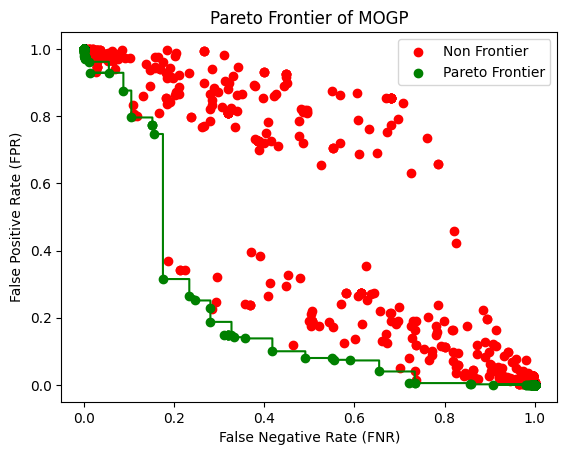

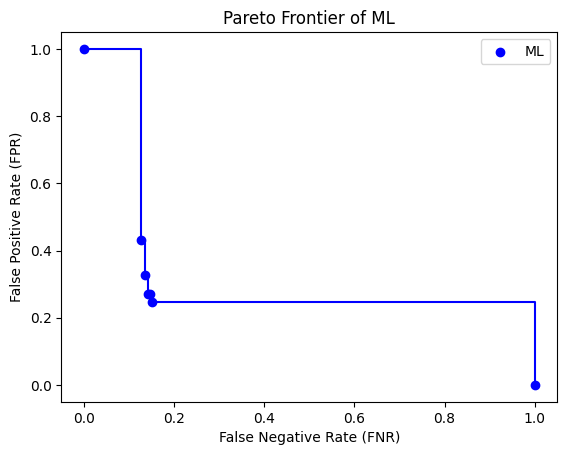

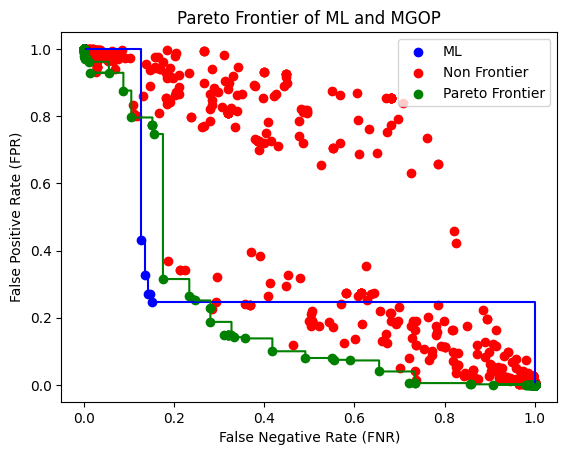

Area Under Curve: 0.2782784222243526
---------Generation 0 ------------
-----FNR----
Mean:  0.5009649122807015
SD:  0.4328289310105253
-----FPR----
Mean:  0.5014681238615669
SD:  0.45476384836145195
---------Generation 1 ------------
-----FNR----
Mean:  0.5036695906432744
SD:  0.43299169293882656
-----FPR----
Mean:  0.4969216757741345
SD:  0.4543057279486276
---------Generation 2 ------------
-----FNR----
Mean:  0.5078918128654967
SD:  0.42874980400882146
-----FPR----
Mean:  0.4914171220400728
SD:  0.45200203016058826
---------Generation 3 ------------
-----FNR----
Mean:  0.4922309941520463
SD:  0.4270649502433337
-----FPR----
Mean:  0.5109854280510017
SD:  0.4508388251492487
---------Generation 4 ------------
-----FNR----
Mean:  0.4856608187134499
SD:  0.4281790995219142
-----FPR----
Mean:  0.5172386156648452
SD:  0.450680086222644
---------Generation 5 ------------
-----FNR----
Mean:  0.49049122807017514
SD:  0.43086694322723024
-----FPR----
Mean:  0.5156630236794172
SD:  0.450889984

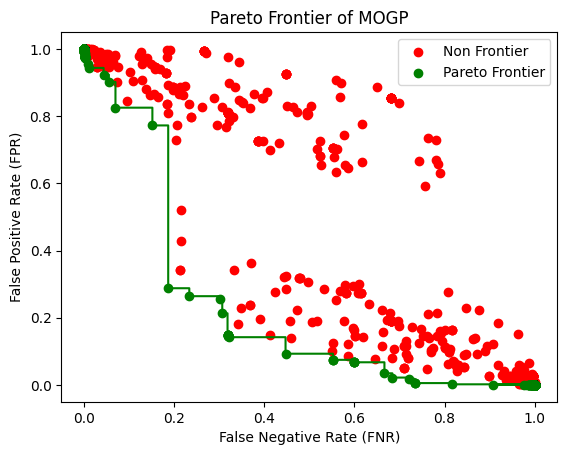

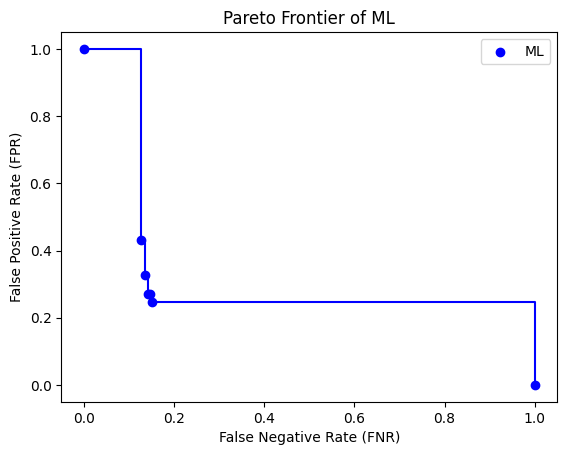

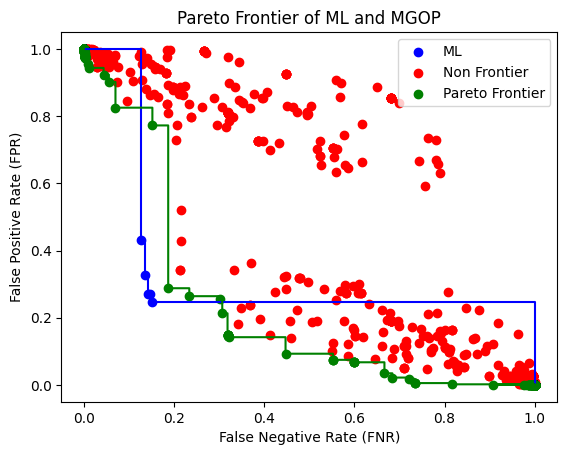

Area Under Curve: 0.196194037005081
---------Generation 0 ------------
-----FNR----
Mean:  0.5053070175438595
SD:  0.43276035995192424
-----FPR----
Mean:  0.5036830601092899
SD:  0.45619419476862816
---------Generation 1 ------------
-----FNR----
Mean:  0.4937514619883037
SD:  0.4356170559211279
-----FPR----
Mean:  0.5137322404371588
SD:  0.4575693626797636
---------Generation 2 ------------
-----FNR----
Mean:  0.5034970760233917
SD:  0.43122455282422123
-----FPR----
Mean:  0.5013005464480874
SD:  0.4544996068368154
---------Generation 3 ------------
-----FNR----
Mean:  0.5073713450292398
SD:  0.43386265584435363
-----FPR----
Mean:  0.4968633879781423
SD:  0.4546245015401955
---------Generation 4 ------------
-----FNR----
Mean:  0.4948976608187131
SD:  0.42955344091783987
-----FPR----
Mean:  0.5063333333333337
SD:  0.4519418333904778
---------Generation 5 ------------
-----FNR----
Mean:  0.4893947368421051
SD:  0.43093640133570743
-----FPR----
Mean:  0.512650273224044
SD:  0.4527231474

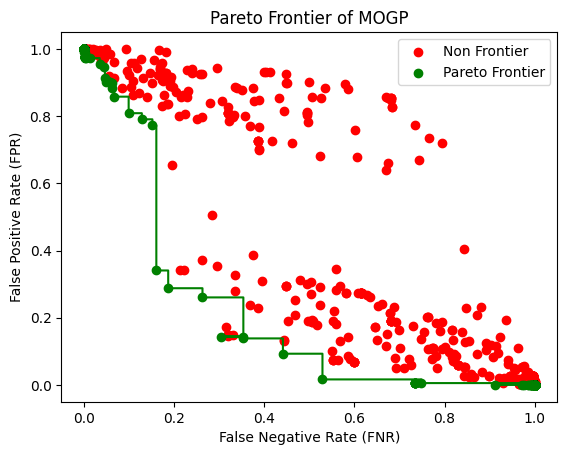

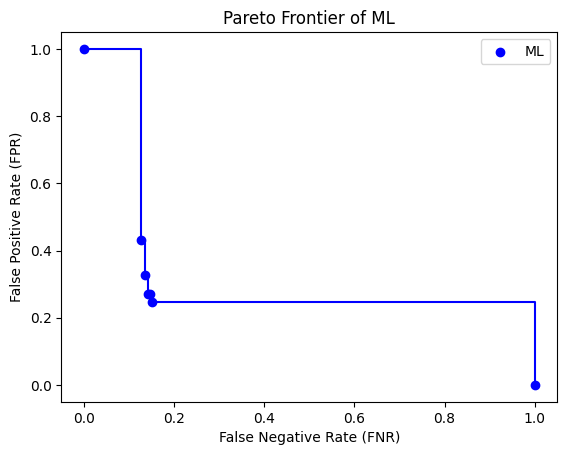

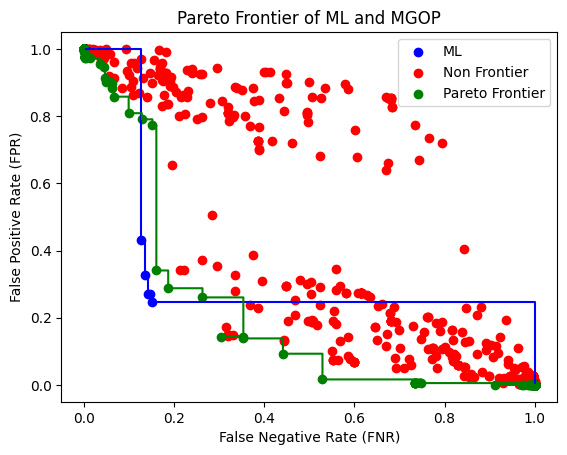

Area Under Curve: 0.21992138816987825
---------Generation 0 ------------
-----FNR----
Mean:  0.4998742690058475
SD:  0.4298719704828474
-----FPR----
Mean:  0.5009089253187613
SD:  0.45405152035068796
---------Generation 1 ------------
-----FNR----
Mean:  0.4965292397660812
SD:  0.42833235459147473
-----FPR----
Mean:  0.5042768670309649
SD:  0.4547177388846084
---------Generation 2 ------------
-----FNR----
Mean:  0.4987134502923971
SD:  0.4304499806025786
-----FPR----
Mean:  0.501812386156648
SD:  0.4557419272946918
---------Generation 3 ------------
-----FNR----
Mean:  0.5029035087719298
SD:  0.42966796040288985
-----FPR----
Mean:  0.5005537340619307
SD:  0.45434888605098545
---------Generation 4 ------------
-----FNR----
Mean:  0.5096959064327482
SD:  0.43075241127682656
-----FPR----
Mean:  0.4903515482695815
SD:  0.454433221743356
---------Generation 5 ------------
-----FNR----
Mean:  0.5018391812865496
SD:  0.42855963532000274
-----FPR----
Mean:  0.49826593806921693
SD:  0.45417602

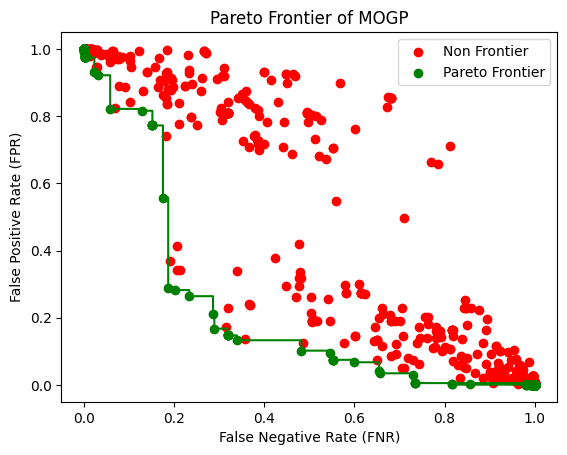

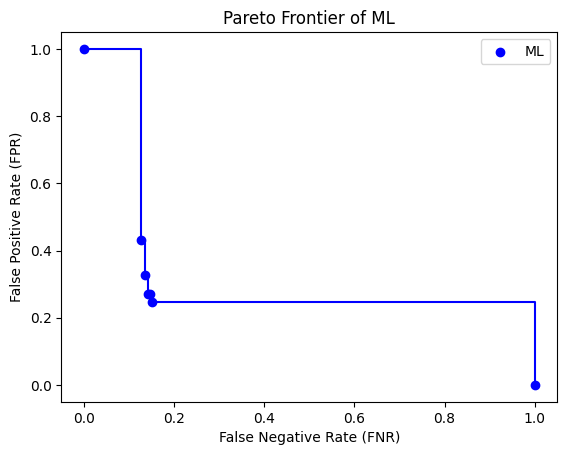

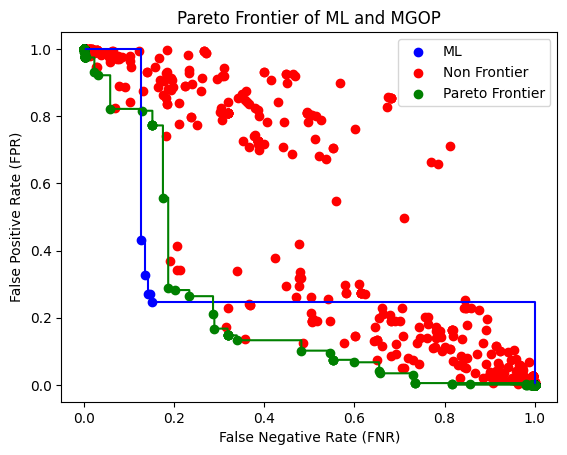

Area Under Curve: 0.20998306330489244
---------Generation 0 ------------
-----FNR----
Mean:  0.5032777777777774
SD:  0.43071339017682914
-----FPR----
Mean:  0.5055628415300547
SD:  0.4549703392258479
---------Generation 1 ------------
-----FNR----
Mean:  0.49521052631578877
SD:  0.4336857931218244
-----FPR----
Mean:  0.5102440801457195
SD:  0.4568231807847111
---------Generation 2 ------------
-----FNR----
Mean:  0.5071549707602333
SD:  0.43288866064572074
-----FPR----
Mean:  0.4976502732240437
SD:  0.4558994335188061
---------Generation 3 ------------
-----FNR----
Mean:  0.5113333333333331
SD:  0.4354650063539342
-----FPR----
Mean:  0.4956921675774134
SD:  0.4574447128266767
---------Generation 4 ------------
-----FNR----
Mean:  0.4939502923976603
SD:  0.4311753671636709
-----FPR----
Mean:  0.5062695810564659
SD:  0.45357056836124515
---------Generation 5 ------------
-----FNR----
Mean:  0.5056520467836252
SD:  0.4313126814464174
-----FPR----
Mean:  0.49012021857923443
SD:  0.45319980

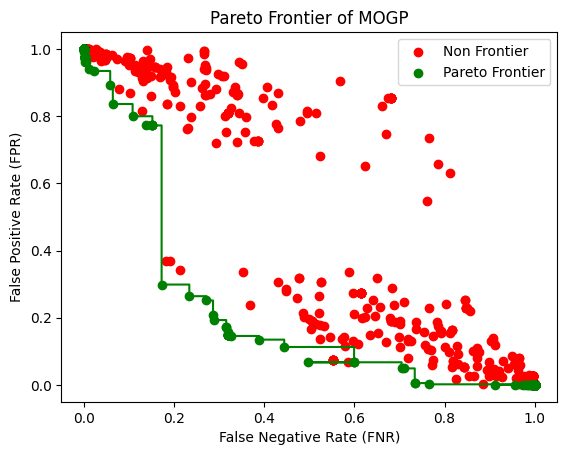

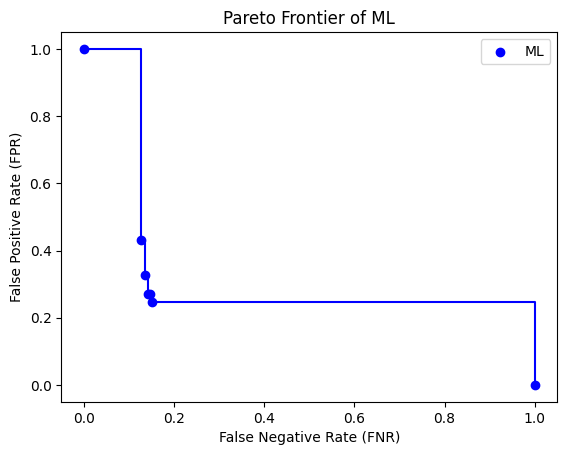

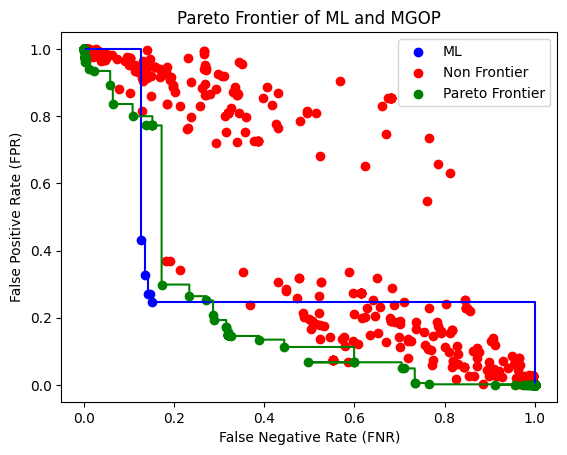

Area Under Curve: 0.2345892052535711
---------Generation 0 ------------
-----FNR----
Mean:  0.5166725146198828
SD:  0.43304363255376155
-----FPR----
Mean:  0.48806739526411647
SD:  0.4554169756898001
---------Generation 1 ------------
-----FNR----
Mean:  0.497754385964912
SD:  0.43752960079062675
-----FPR----
Mean:  0.5084134790528226
SD:  0.45822546872385095
---------Generation 2 ------------
-----FNR----
Mean:  0.5018421052631574
SD:  0.43333083847566506
-----FPR----
Mean:  0.5017668488160286
SD:  0.45760310625185796
---------Generation 3 ------------
-----FNR----
Mean:  0.5030964912280697
SD:  0.4359259194657542
-----FPR----
Mean:  0.49728051001821466
SD:  0.45850219468465975
---------Generation 4 ------------
-----FNR----
Mean:  0.5010438596491228
SD:  0.43526164494144015
-----FPR----
Mean:  0.5068579234972677
SD:  0.45799715089105214
---------Generation 5 ------------
-----FNR----
Mean:  0.49732456140350806
SD:  0.4362723193155918
-----FPR----
Mean:  0.5160145719489982
SD:  0.4594

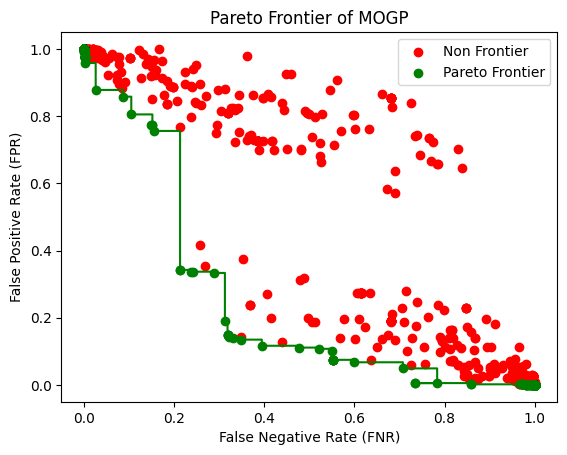

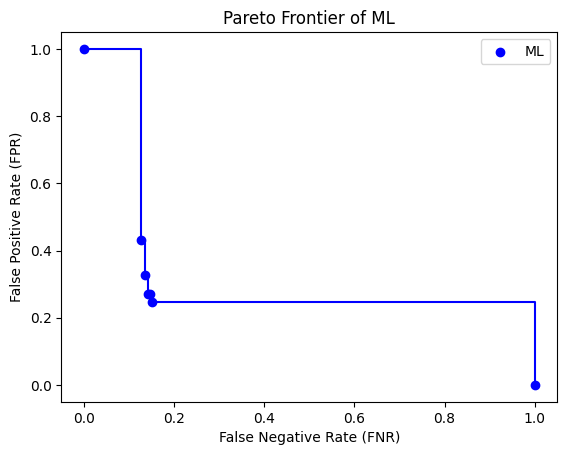

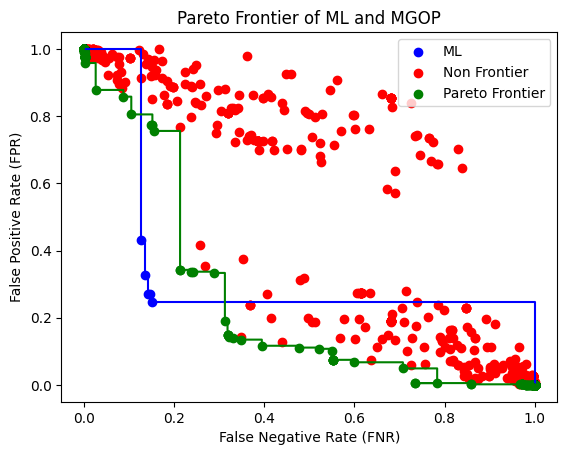

Area Under Curve: 0.22415023594201045
---------Generation 0 ------------
-----FNR----
Mean:  0.4994707602339182
SD:  0.43533557989580385
-----FPR----
Mean:  0.5045409836065576
SD:  0.4574239041815529
---------Generation 1 ------------
-----FNR----
Mean:  0.48809064327485374
SD:  0.43209589706149637
-----FPR----
Mean:  0.5141347905282332
SD:  0.45446417935800043
---------Generation 2 ------------
-----FNR----
Mean:  0.4822573099415203
SD:  0.4312537540905852
-----FPR----
Mean:  0.5146193078324226
SD:  0.4532164483268577
---------Generation 3 ------------
-----FNR----
Mean:  0.48808479532163723
SD:  0.43517624876496086
-----FPR----
Mean:  0.5108943533697639
SD:  0.456200464382898
---------Generation 4 ------------
-----FNR----
Mean:  0.4920263157894734
SD:  0.4326117658744178
-----FPR----
Mean:  0.5090072859744995
SD:  0.45494369151142566
---------Generation 5 ------------
-----FNR----
Mean:  0.4840701754385969
SD:  0.4393515070253977
-----FPR----
Mean:  0.5154134790528242
SD:  0.4581345

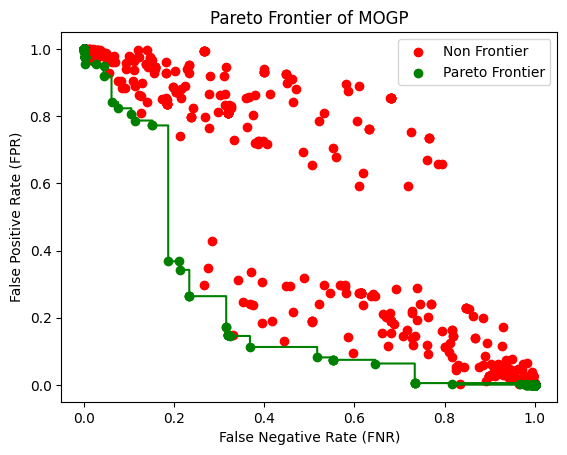

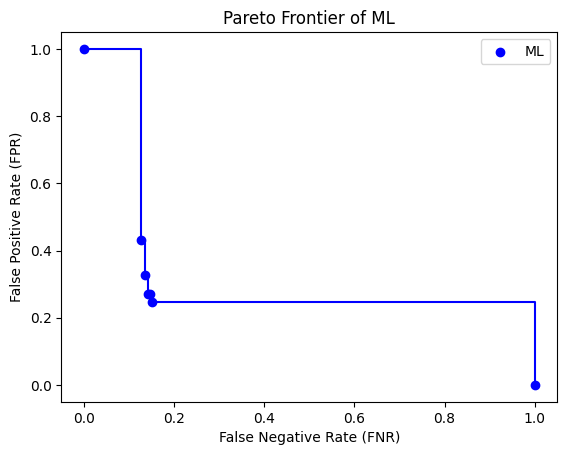

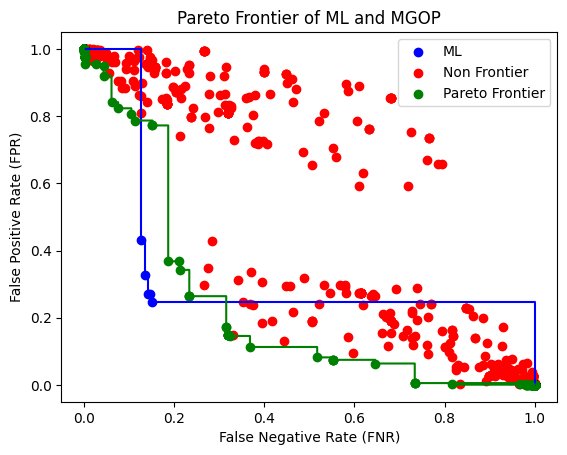

Area Under Curve: 0.19906475356576017
---------Generation 0 ------------
-----FNR----
Mean:  0.5071228070175435
SD:  0.43219974590670535
-----FPR----
Mean:  0.49336429872495446
SD:  0.45427029431490185
---------Generation 1 ------------
-----FNR----
Mean:  0.49359941520467826
SD:  0.4328654149008973
-----FPR----
Mean:  0.5072823315118397
SD:  0.4556332664596961
---------Generation 2 ------------
-----FNR----
Mean:  0.5073830409356721
SD:  0.4338510471212437
-----FPR----
Mean:  0.4942969034608377
SD:  0.45495781705912264
---------Generation 3 ------------
-----FNR----
Mean:  0.503406432748537
SD:  0.4332564169944461
-----FPR----
Mean:  0.49771584699453536
SD:  0.45544114426607657
---------Generation 4 ------------
-----FNR----
Mean:  0.49653216374268927
SD:  0.43504088406506186
-----FPR----
Mean:  0.5044881602914385
SD:  0.45762224566506926
---------Generation 5 ------------
-----FNR----
Mean:  0.49593567251461945
SD:  0.43770316333983755
-----FPR----
Mean:  0.5059672131147545
SD:  0.45

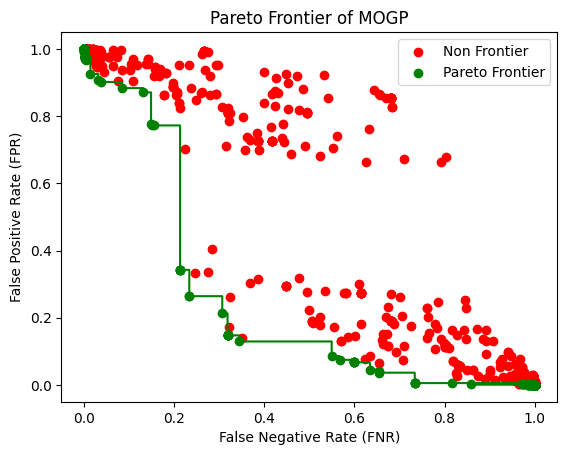

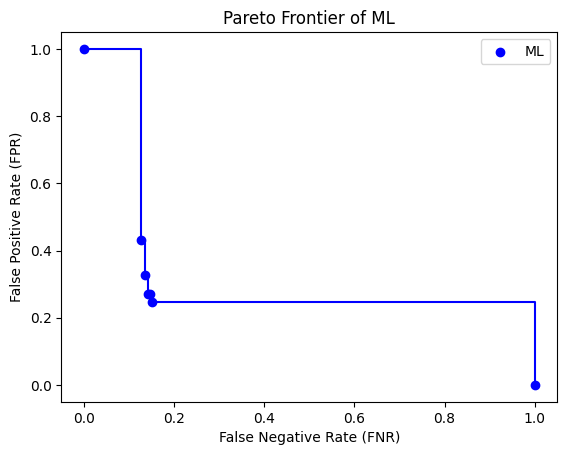

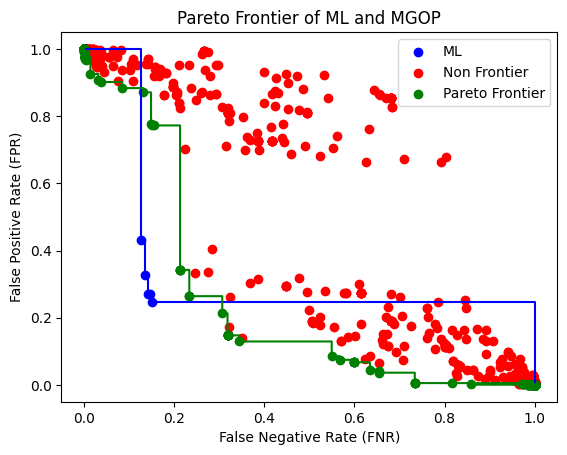

Area Under Curve: 0.2158310165212667
---------Generation 0 ------------
-----FNR----
Mean:  0.5011578947368418
SD:  0.4300183473729024
-----FPR----
Mean:  0.5029581056466301
SD:  0.4558312693577142
---------Generation 1 ------------
-----FNR----
Mean:  0.5044385964912275
SD:  0.42978103447508376
-----FPR----
Mean:  0.49822768670309703
SD:  0.4543931426220603
---------Generation 2 ------------
-----FNR----
Mean:  0.506336257309941
SD:  0.43007295912553195
-----FPR----
Mean:  0.49576867030965427
SD:  0.4530011127637559
---------Generation 3 ------------
-----FNR----
Mean:  0.5085584795321633
SD:  0.43367320280343913
-----FPR----
Mean:  0.4943661202185795
SD:  0.4564049931097456
---------Generation 4 ------------
-----FNR----
Mean:  0.5093011695906428
SD:  0.4321433677409376
-----FPR----
Mean:  0.48880692167577405
SD:  0.4549638047648482
---------Generation 5 ------------
-----FNR----
Mean:  0.5031959064327478
SD:  0.43456388196634554
-----FPR----
Mean:  0.49601457194899823
SD:  0.4554294

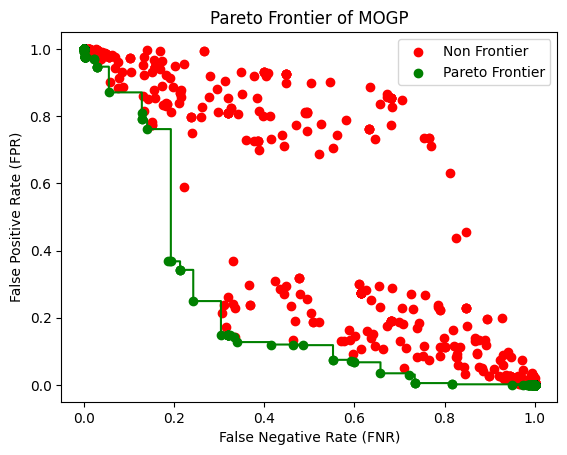

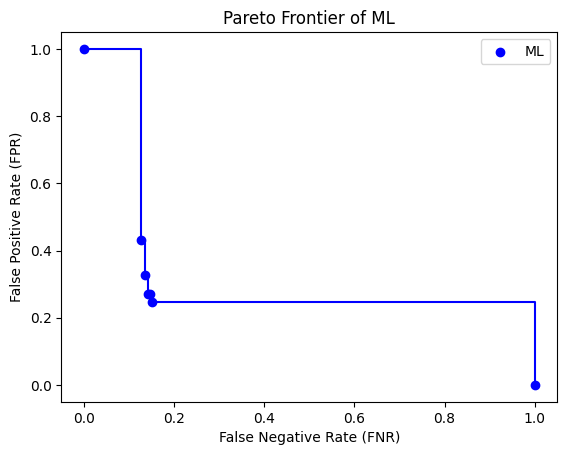

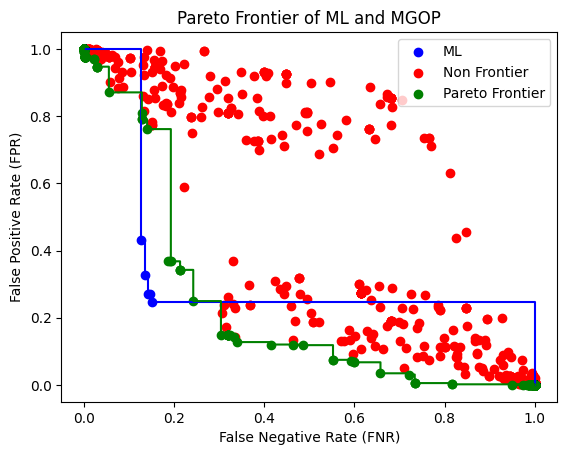

Area Under Curve: 0.21268334771354613
---------Generation 0 ------------
-----FNR----
Mean:  0.5260116959064326
SD:  0.4326749896406204
-----FPR----
Mean:  0.4720145719489982
SD:  0.45377111002270704
---------Generation 1 ------------
-----FNR----
Mean:  0.5204853801169584
SD:  0.4350709371959939
-----FPR----
Mean:  0.47668670309653954
SD:  0.45625718101041507
---------Generation 2 ------------
-----FNR----
Mean:  0.5028421052631572
SD:  0.43607237837539126
-----FPR----
Mean:  0.49556648451730406
SD:  0.4571339723987634
---------Generation 3 ------------
-----FNR----
Mean:  0.4884970760233912
SD:  0.43408058823311974
-----FPR----
Mean:  0.5031147540983606
SD:  0.4552764410424613
---------Generation 4 ------------
-----FNR----
Mean:  0.49426900584795286
SD:  0.43207706717322836
-----FPR----
Mean:  0.4988160291438978
SD:  0.4540764536160351
---------Generation 5 ------------
-----FNR----
Mean:  0.5011403508771923
SD:  0.4301582614809558
-----FPR----
Mean:  0.49490163934426196
SD:  0.4532

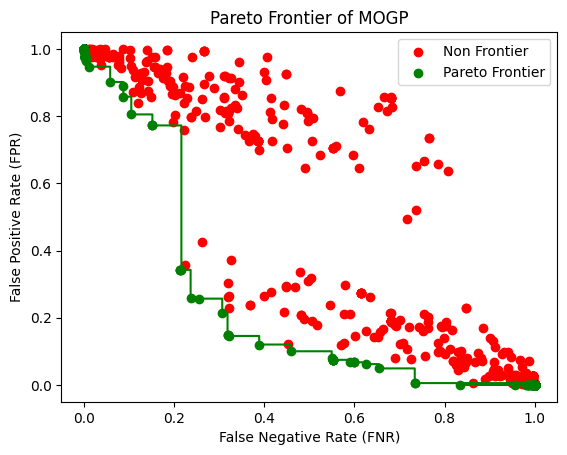

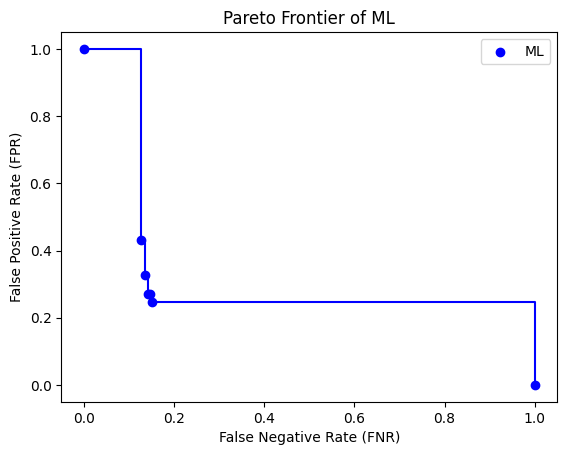

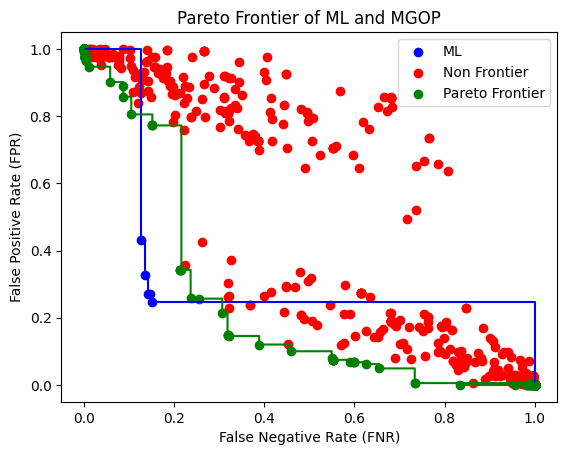

Area Under Curve: 0.20701647865869896
-------best of the best-----------
5336
308


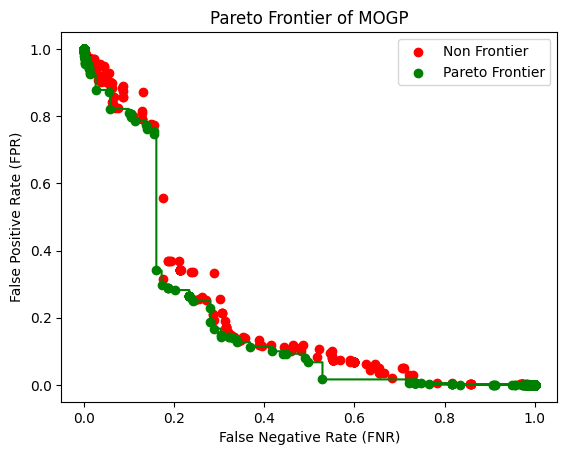

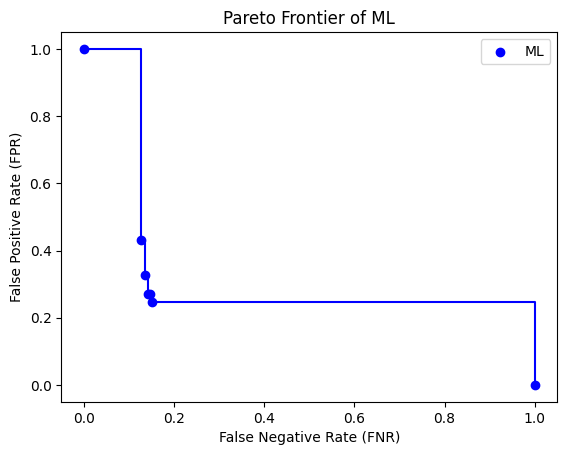

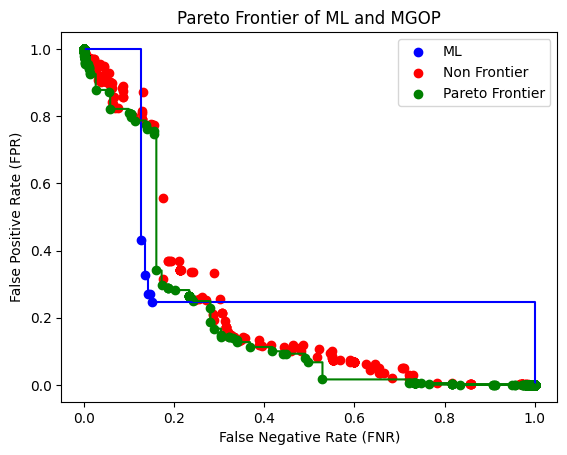

Area Under Curve: 0.18696407077195112


[[<deap.gp.Primitive at 0x1317f67a700>,
 [<deap.gp.Primitive at 0x1317f67aac0>, <deap.gp.Terminal at 0x1317f6d1400>],
 [<deap.gp.Primitive at 0x1317f67aac0>, <deap.gp.Terminal at 0x1317f6d1400>],
 [<deap.gp.Primitive at 0x1317f67aac0>, <deap.gp.Terminal at 0x1317f6d1400>],
 [<deap.gp.Primitive at 0x1317f67aac0>, <deap.gp.Terminal at 0x1317f6d1400>],
 [<deap.gp.Primitive at 0x1317f67aac0>, <deap.gp.Terminal at 0x1317f6d1400>],
 [<deap.gp.Primitive at 0x1317f67aac0>, <deap.gp.Terminal at 0x1317f6d1340>],
 [<deap.gp.Primitive at 0x1317f67aac0>, <deap.gp.Terminal at 0x1317f6d1340>],
 [<deap.gp.Primitive at 0x1317f67aac0>, <deap.gp.Terminal at 0x1317f6d1340>],
 [<deap.gp.Primitive at 0x1317f67aac0>, <deap.gp.Terminal at 0x1317f6d1400>],
 [<deap.gp.Primitive at 0x1317f67aac0>, <deap.gp.Terminal at 0x1317f6d1400>],
 [<deap.gp.Primitive at 0x1317f67aac0>, <deap.gp.Terminal at 0x1317f6d1340>],
 [<deap.gp.Primitive at 0x1317f67aac0>, <deap.gp.Terminal at 0x1317f6d1400>],
 [<deap.gp.Primitive at 

In [17]:
param=[(0.2,0.2), (0.4, 0.05), (0.3,0.1), (0.4,0.1), (0.5,0.1),(0.6,0.1), (0.7,0.1), (0.5,0.05), (0.5,0.15), (0.5, 0.2)]
optimalIndividuals = []
for i in range(len(param)):
    curr_pop = evo_algo(1000, 100, param[i][0], param[i][1])
    plotPareto(curr_pop, optimalIndividuals)
print("-------best of the best-----------")
#run evolution with this popultaion as the starting point
finalPareto = []
plotPareto(optimalIndividuals,finalPareto)

In [18]:
print(len(optimalIndividuals))

5644


5336
308


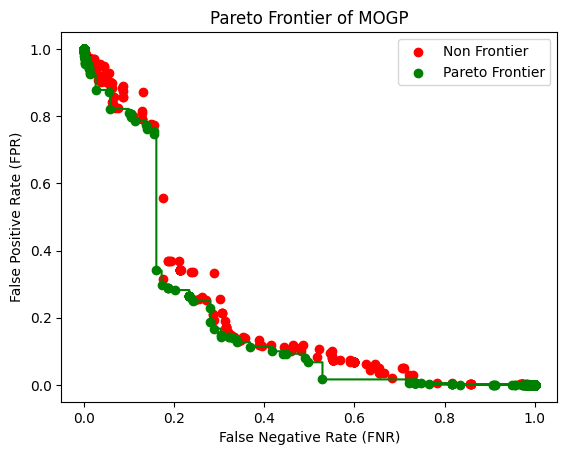

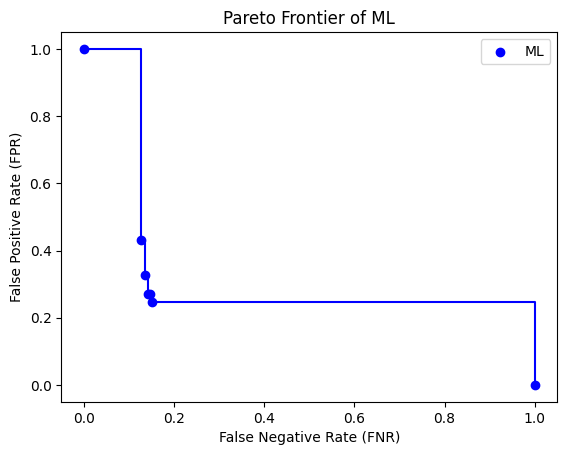

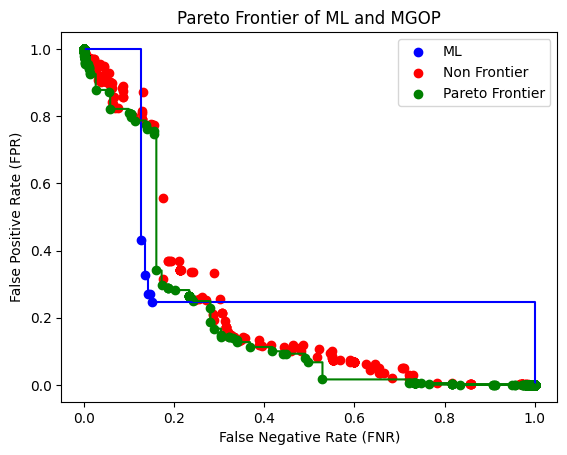

Area Under Curve: 0.18696407077195112


In [20]:
templist = []
templist = plotPareto(optimalIndividuals, templist)

---------Generation 0 ------------
-----FNR----
Mean:  0.4764724532806146
SD:  0.4785119180758067
-----FPR----
Mean:  0.5046579761669632
SD:  0.4857105476328283
---------Generation 1 ------------
-----FNR----
Mean:  0.49232430236943703
SD:  0.47313557953758234
-----FPR----
Mean:  0.49168774099935536
SD:  0.481933542445398
---------Generation 2 ------------
-----FNR----
Mean:  0.4867322748165001
SD:  0.46803601579758536
-----FPR----
Mean:  0.49970663754342304
SD:  0.4785815862978446
---------Generation 3 ------------
-----FNR----
Mean:  0.48907290669385534
SD:  0.46423734720311877
-----FPR----
Mean:  0.5016375369688328
SD:  0.4762246279685953
---------Generation 4 ------------
-----FNR----
Mean:  0.4854904654738669
SD:  0.4627369076631457
-----FPR----
Mean:  0.5044620784649354
SD:  0.47509947759099347
---------Generation 5 ------------
-----FNR----
Mean:  0.48447919645558524
SD:  0.46043519616707973
-----FPR----
Mean:  0.5083961690542296
SD:  0.4734578184595191
---------Generation 6 ---

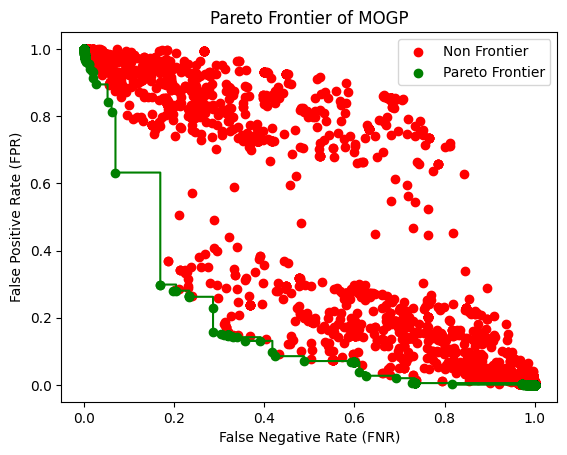

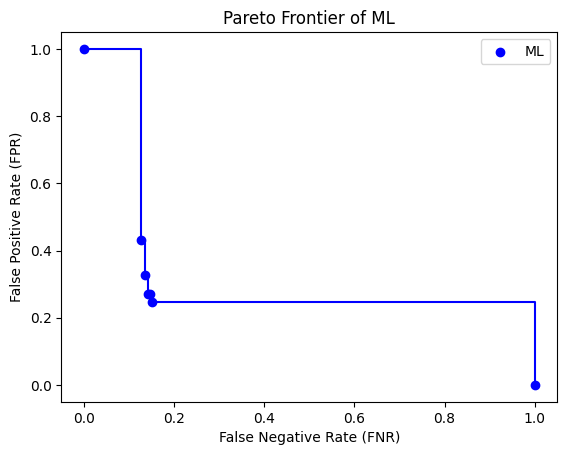

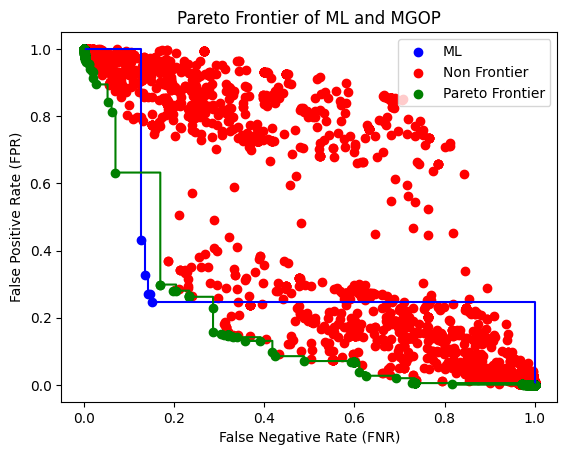

Area Under Curve: 0.17435209152206563


In [21]:
best_pop = evo_algo(5644, 100, 0.5, 0.1, optimalIndividuals)
templist = plotPareto(best_pop, templist)

3239
2405


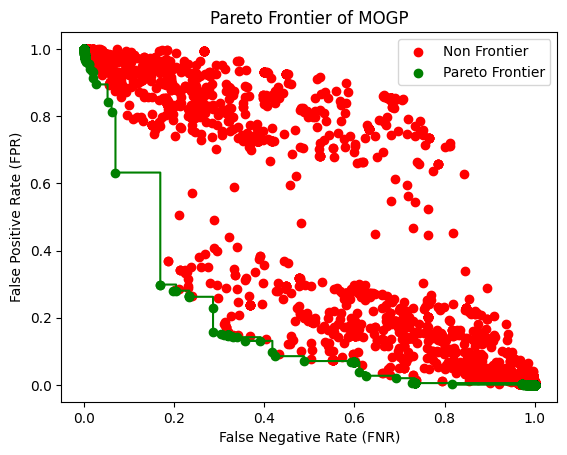

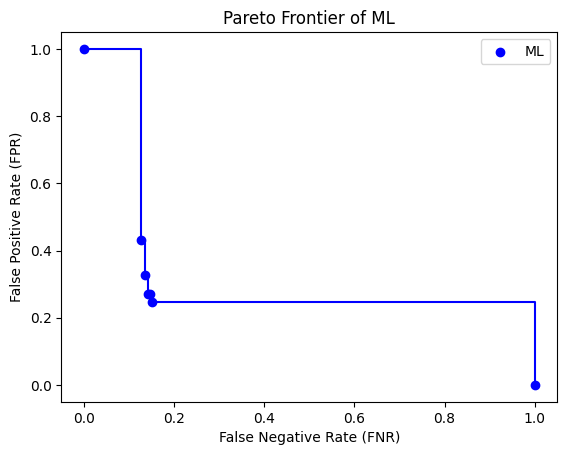

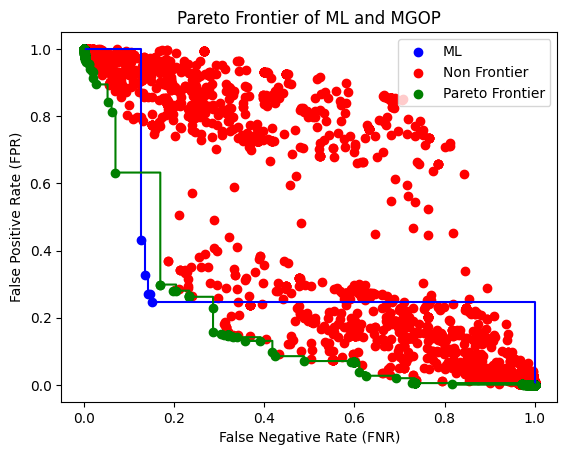

3239
Area Under Curve: 0.17435209152206563


In [24]:
templist = plotPareto(best_pop, templist)

3
0


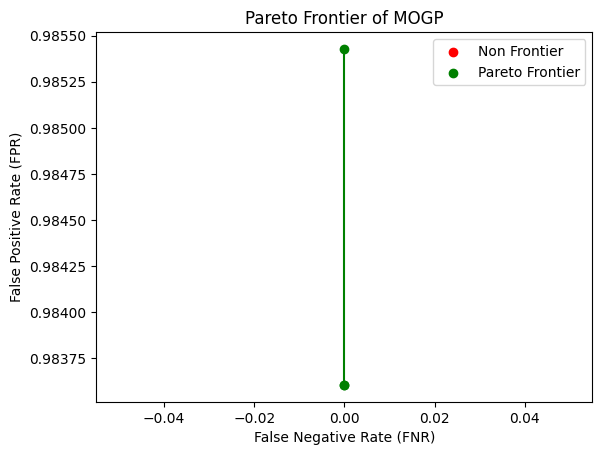

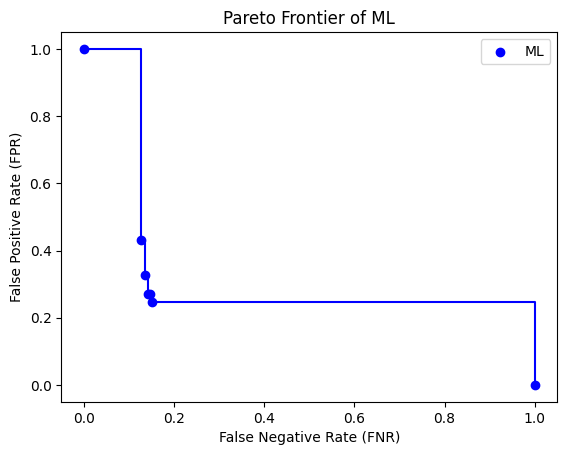

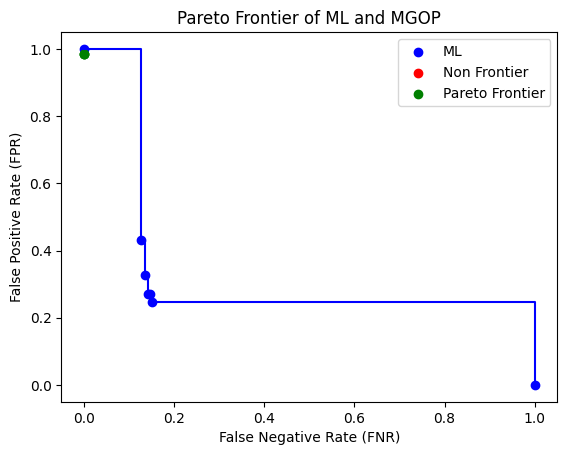

3
Area Under Curve: 0.0


In [29]:
b = tools.selBest(best_pop, 3)
t = []
t =plotPareto(b,t)